In [12]:
from alice import Alice
from bob import Bob

from partial_key_recovery import attack

import sys
sys.path.append('..')

from metrics import key_recovery_metrics
from qkd import execute_qkd

import pandas as pd

In [13]:
public, private = execute_qkd(Alice, Bob, 16, DEBUG = True)

Key exchange completed, here's the data:
Alice send pairs: {0: '1x,1z', 1: '1x,0z', 2: '0x,1z', 3: '1x,0z', 4: '1x,1z', 5: '1x,0z', 6: '1x,1z', 7: '1x,1z', 8: '0x,0z', 9: '1x,1z', 10: '0x,0z', 11: '1x,1z', 12: '1x,1z', 13: '1x,1z', 14: '0x,0z', 15: '0x,1z'}
Bob send double matchings: [0, 4, 5, 8, 9, 13, 14, 15]
Alice send usable frames: [(0, 4, 5), (0, 4, 15), (0, 5, 8), (0, 5, 14), (0, 9, 15), (0, 13, 15), (4, 5, 8), (4, 5, 14), (4, 9, 15), (4, 13, 15), (5, 9, 13), (5, 9, 14), (5, 13, 14), (8, 9, 15), (8, 13, 15), (9, 13, 15)]
Bob send sifting string: ['101', '001', '111', '111', '111', '001', '111', '111', '111', '001', '011', '000', '110', '100', '010', '110']
Bob send measured string: ['111', '110', '110', '110', '110', '110', '110', '110', '110', '110', '111', '110', '110', '010', '010', '110']
Bob shared key: 101101111111111101111111111101100000010000010010
Alice shared key: 101101111111111101111111111101100000010000010010


In [8]:
VALID_SS = [
    "111,110",
    "111,011",
    "110,110",
    "110,011",
    "101,111",
    "101,100",
    "101,001",
    "100,111",
    "100,100",
    "100,010",
    "100,001",
    "011,111",
    "011,100",
    "011,010",
    "011,001",
    "010,111",
    "010,100",
    "010,010",
    "010,001",
    "001,110",
    "000,110",
    "000,011"
]

key_recovery_metrics(execute_qkd, Alice, Bob, 16, attack, 3, VALID_SS)

{'double_matchings': [3, 5, 10, 11, 13, 15],
 'bits_recovered': 21,
 'bits': 27,
 '%': 0.7777777777777778,
 'SS_left': ['010,001', '010,001']}

In [19]:
pairs = 256

VALID_SS = [
    "111,110",
    "111,011",
    "110,110",
    "110,011",
    "101,111",
    "101,100",
    "101,001",
    "100,111",
    "100,100",
    "100,010",
    "100,001",
    "011,111",
    "011,100",
    "011,010",
    "011,001",
    "010,111",
    "010,100",
    "010,010",
    "010,001",
    "001,110",
    "000,110",
    "000,011"
]

try:
    df = pd.read_csv("results.csv")
except:
    file = open("results.csv", "w")
    file.write("double_matchings,bits_recovered,bits,%")
    file.close()
    df = pd.read_csv("results.csv")

while True:
    results = key_recovery_metrics(execute_qkd, Alice, Bob, pairs, attack, 3, VALID_SS)
    
    if not results: continue

    df.loc[len(df)] = [ len(results["double_matchings"]), results["bits_recovered"], results["bits"], results["%"] ]
    
    df.to_csv("results.csv", index = False)

KeyboardInterrupt: 

<AxesSubplot:xlabel='double_matchings', ylabel='%'>

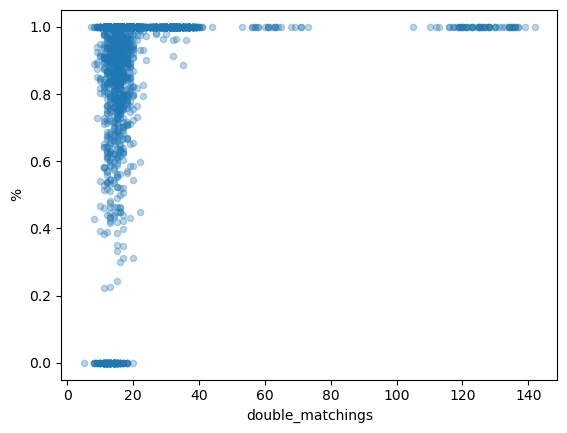

In [33]:
df = pd.read_csv("results.csv")
df.plot.scatter(x = "double_matchings", y = "%", alpha = 0.3)